# Analysis of Chemicals in Cosmetic Products 
___

## 1. Load data and preprocessing 

#### Import libraries

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Declare constants 

In [2]:
# Variables with the names of each column in data
CDPHID_COLUMN                 = 'CDPHId'
PRODUCTNAME_COLUMN            = 'ProductName'
CSFID_COLUMN                  = 'CSFId'
CSF_COLUMN                    = 'CSF'
COMPANYID_COLUMN              = 'CompanyId'
COMPANYNAME_COLUMN            = 'CompanyName'
BRANDNAME_COLUMN              = 'BrandName'
PRIMARYCATEGORYID_COLUMN      = 'PrimaryCategoryId'
PRIMARYCATEGORY_COLUMN        = 'PrimaryCategory'
SUBCATEGORYID_COLUMN          = 'SubCategoryId'
SUBCATEGORY_COLUMN            = 'SubCategory'
CASID_COLUMN                  = 'CasId'
CASNUMBER_COLUMN              = 'CasNumber'
CHEMICALID_COLUMN             = 'ChemicalId'
CHEMICALNAME_COLUMN           = 'ChemicalName'
INITIALDATEREPORTED_COLUMN    = 'InitialDateReported'
MOSTRECENTDATEREPORTED_COLUMN = 'MostRecentDateReported'
DISCONTINUEDDATE_COLUMN       = 'DiscontinuedDate'
CHEMICALCREATEDAT_COLUMN      = 'ChemicalCreatedAt'
CHEMICALUPDATEDAT_COLUMN      = 'ChemicalUpdatedAt'
CHEMICALDATEREMOVED_COLUMN    = 'ChemicalDateRemoved'
CHEMICALCOUNT_COLUMN          = 'ChemicalCount'

# Number to replace empty value in CSFId column
CSFID_EMPTY_NUMBER  = -1
# Date value which means NaT 
NAT_DATE            = datetime.date(1900,1,1)

# List of columns which contains a Names
list_names = [ PRODUCTNAME_COLUMN, CSF_COLUMN, COMPANYNAME_COLUMN, BRANDNAME_COLUMN, 
               PRIMARYCATEGORY_COLUMN, SUBCATEGORY_COLUMN, CHEMICALNAME_COLUMN ]

# List of columns which contains a Dates
list_dates = [ INITIALDATEREPORTED_COLUMN, MOSTRECENTDATEREPORTED_COLUMN, DISCONTINUEDDATE_COLUMN,
               CHEMICALCREATEDAT_COLUMN, CHEMICALUPDATEDAT_COLUMN, CHEMICALDATEREMOVED_COLUMN ]

# Other columns
list_ids   = [ CDPHID_COLUMN, CSFID_COLUMN, COMPANYID_COLUMN, PRIMARYCATEGORYID_COLUMN, 
               SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN ]

### Load data 

In [3]:
# Load data from data/ folder
data = pd.read_csv('data/cscpopendata.csv', sep = ',', parse_dates = list_dates)

# pd.isna() --> for NaN
# <value> is pd.NaT --> for NaT

# Fill NaT with 01/01/2500
for date_column in list_dates :
    data[date_column] = data[date_column].apply(lambda x: NAT_DATE if x is pd.NaT else x)
    

# Fill NA with ''
data = data.fillna('')

# Fill CSFId empty with -1
data[CSFID_COLUMN] = data[CSFID_COLUMN].apply(lambda x: x if x != "" else CSFID_EMPTY_NUMBER)

data.head()

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,-1.0,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,1900-01-01,1
1,3,Glover's Medicated Shampoo,-1.0,,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,65996-92-1,4,Distillates (coal tar),2009-07-01,2009-07-01,1900-01-01,2009-07-01,2009-07-01,1900-01-01,2
2,3,Glover's Medicated Shampoo,-1.0,,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,140-67-0,5,Estragole,2009-07-01,2009-07-01,1900-01-01,2009-07-02,2009-07-02,1900-01-01,2
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,-1.0,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,13463-67-7,7,Titanium dioxide,2009-07-09,2013-08-28,1900-01-01,2009-07-09,2009-07-09,1900-01-01,1
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,-1.0,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,13463-67-7,8,Titanium dioxide,2009-07-09,2013-08-28,2011-02-01,2009-07-09,2009-07-09,1900-01-01,1


#### Aggreate data 

In [4]:
# Add to 'data' a column for each 'date_column' in 'list_dates' with the year and month of each date 
list_year_month = []

for date_column in list_dates :
    data[date_column + '_Year'] = data[date_column].apply(lambda x: x.year)
    data[date_column + '_Month'] = data[date_column].apply(lambda x: x.month)
    
    list_year_month.append(date_column + '_Year')
    list_year_month.append(date_column + '_Month')
    
    
# Remove all rows that have a cosmetic product discontinued
to_aggregate = data[data[DISCONTINUEDDATE_COLUMN + "_Year"] == NAT_DATE.year]

# Remove all rows that have a chemical removed
to_aggregate = data[data[CHEMICALDATEREMOVED_COLUMN + "_Year"] == NAT_DATE.year]    

# Remove all columns with DISCONTINUEDDATE_COLUMN and CHEMICALDATEREMOVED_COLUMN values
columns = [ col for col in list_year_month 
                   if DISCONTINUEDDATE_COLUMN not in col and CHEMICALDATEREMOVED_COLUMN not in col ]

# Add to columns 
columns = columns + [SUBCATEGORYID_COLUMN, CASID_COLUMN]

# Aggregate data
data_aggregated = pd.DataFrame(to_aggregate.groupby(columns, as_index = False)
                                               .agg({CHEMICALCOUNT_COLUMN : 'sum'}))
data_aggregated.head()

,InitialDateReported_Year,InitialDateReported_Month,MostRecentDateReported_Year,MostRecentDateReported_Month,ChemicalCreatedAt_Year,ChemicalCreatedAt_Month,ChemicalUpdatedAt_Year,ChemicalUpdatedAt_Month,SubCategoryId,CasId,ChemicalCount
0,2009,6,2013,8,2009,7,2009,7,53,656,1
1,2009,7,2009,7,2009,7,2009,7,25,293,2
2,2009,7,2009,7,2009,7,2009,7,25,889,2
3,2009,7,2010,6,2010,6,2010,6,60,656,1
4,2009,7,2010,12,2009,12,2009,12,60,656,3


### Features selection

#### Functions definition 

In [5]:
def calculateVIF(data) :
    """
    Calculate VIF (Variance Inflation Factor) of data. 
    
    VIF allows us cuantify the intensity of multicollinearity. The VIF value increases according
    to the multicollinearity increases. The VIF values bigger than 5 are considered high and
    VIF values bigger than 10 are considered very high.
    
    Params:
    data -- data.
    
    Returns:
    A dataframe with the VIF value of each feature.
    """
    features = list(data.columns)
    num_features = len(features)
    
    # Create the model and the result dataframe
    model = LinearRegression()
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    # For each feature
    for ite in range(num_features) :
        x_features = features[:]
        y_feature  = features[ite]
        # Remove the feature (because it is the independient)
        x_features.remove(y_feature)
        
        x = data[x_features]
        y = data[y_feature]
        
        # Fit the model 
        model.fit(x, y)
        # Calculate VIF
        result[y_feature] = 1 / (1 - model.score(x, y))
    
    return result


def selectDataUsingVIF(data, max_VIF = 5) :
    """
    Select features using its VIF value.
    
    Params:
    data -- data.
    max_VIF -- maximum VIF value to follow removing features.
    
    Returns:
    A dataframe with the features selected.
    """
    
    # Copy data
    result = data.copy(deep = True)
    
    # Calculate VIF of all features
    VIF = calculateVIF(result)
    
    # While the VIF value is bigger than max_VIF:
    while VIF.values.max() > max_VIF :
        # Get the column of the feature which gets the maximum VIF
        col_max = np.where(VIF == VIF.values.max())[1][0]
        
        # Remove this feature of the data
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        # Again, calculate VIF
        VIF = calculateVIF(result)

    # Return the result
    return result

___

In [6]:
# Select features using VIF method
data_aggregated = selectDataUsingVIF(data_aggregated)
data_aggregated.head()

,InitialDateReported_Year,InitialDateReported_Month,MostRecentDateReported_Year,MostRecentDateReported_Month,ChemicalUpdatedAt_Month,SubCategoryId,CasId,ChemicalCount
0,2009,6,2013,8,7,53,656,1
1,2009,7,2009,7,7,25,293,2
2,2009,7,2009,7,7,25,889,2
3,2009,7,2010,6,6,60,656,1
4,2009,7,2010,12,12,60,656,3


In [7]:
print('data.shape = ', data.shape)
print('data_aggregated.shape = ', data_aggregated.shape)

data.shape =  (96896, 34)
data_aggregated.shape =  (9085, 8)


___

## 2. Clustering 

#### Functions definition 

In [8]:
def dates_to_clustering(data, date_columns) :
    """
    Convert the columns with date values to timestamp values.
    
    Params:
    data -- data whose columns will be converted.
    date_columns -- list which contains the columns with date values.
    
    Return:
    A data copy with the date columns converted to timestamp.
    """
    
    to_clustering = data.copy(deep = True)
    
    for col in date_columns :
        to_clustering[col] = data[col].apply(lambda x: x.timestamp() if x is pd.Timestamp else x )
        
    return to_clustering


def clustering_to_dates(data, date_columns) :
    """
    Convert the columns with timestamp values to date values.
    
    Params:
    data -- data whose columns will be converted.
    date_columns -- list which contains the columns with timestamp values.
    
    Return:
    A data copy with the date columns converted to date.
    """
        
    to_dates = data.copy(deep = True)
    
    for col in date_columns :
        to_dates[col] = data[col].apply(lambda x: datetime.date.fromtimestamp(x))
        
    return to_dates


def plot_silhouette(data, min_k, max_k, n_init, text_title) :
    """
    Get the number of cluster to apply KMeans using the Silhouette coeffiecient.
    Plot the Silhouette coefficiente before applying KMeans to several number of clusters.
    
    The Silhouette coefficient is defined like the difference between mean distance to closest 
    cluster's elements and mean intra-cluster distance of the cluster's element divide by the maximum of them.
    
    The Silhouette coefficient is implemented in sklearn.metrics with the silhouette_score() method.
    
    Params:
    data        -- data to get the number of clusters.
    max_k       -- maximun of clusters to apply the Silhouette coefficient. It have to be higher than 2.
    n_init      -- maximum number which the algorithm will be executed.
    """
    
    silhouette_avgs = []
    
    for k in range(min_k, max_k):
        # Object kmeans 
        kmeans = KMeans(n_clusters = k, 
                        n_init = n_init)
        # Get Kmeans
        kmeans.fit(data)
        
        score = silhouette_score(data, kmeans.labels_)
        silhouette_avgs.append(score)
    
    # Plot results
    plt.plot(range(min_k, max_k), silhouette_avgs, 'bo-', markersize=5, lw=2)
    plt.xticks(range(min_k, max_k))
    plt.grid(True)
    plt.xlabel('k')
    plt.ylabel('silhouette coefficient')
    plt.title(text_title)


def plot_elbow_method(data, min_k, max_k, n_init, text_title) :
    """
    Get the number of cluster to apply KMeans using the Elbow method. 
    Plot the inertia values before applying KMeans to several number of clusters.
    
    This function is based on the Elbow's implementation of RicardoMoya:
    
    https://github.com/RicardoMoya/OptimalNumClusters/blob/master/Elbow_Method.py
    
    Params:
    data        -- data to get the number of clusters.
    max_k       -- maximun of clusters to apply the Silhouette coefficient. It have to be higher than 2.
    n_init      -- maximum number which the algorithm will be executed.
    """

    inertia_clusters = []
    
    for k in range(min_k, max_k):
        # Object kmeans 
        kmeans = KMeans(n_clusters = k, 
                        n_init = n_init)
        # Get Kmeans
        kmeans.fit(data)
        
        # Obtain inertia
        inertia_clusters.append([k, kmeans.inertia_])
    
    # Plot results
    x, y = zip(*[inertia for inertia in inertia_clusters])
    plt.plot(x, y, 'ro-', markersize=5, lw=2)
    plt.xticks(range(min_k, max_k))
    plt.grid(True)
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.title(text_title)
    plt.show()
    
    
def plot_number_clusters(dataset, min_k, max_k, n_init, title) :
    """
    Function which uses 'plot_silhouette()' and 'plot_elbow_method()' functions
    """
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plot_silhouette(dataset, 
                    min_k = min_k,
                    max_k = max_k, 
                    n_init = n_init, 
                    text_title = title)
    plt.subplot(1, 2, 2)
    plot_elbow_method(dataset, 
                        min_k = min_k,
                        max_k = max_k, 
                        n_init = n_init, 
                        text_title = title)

___

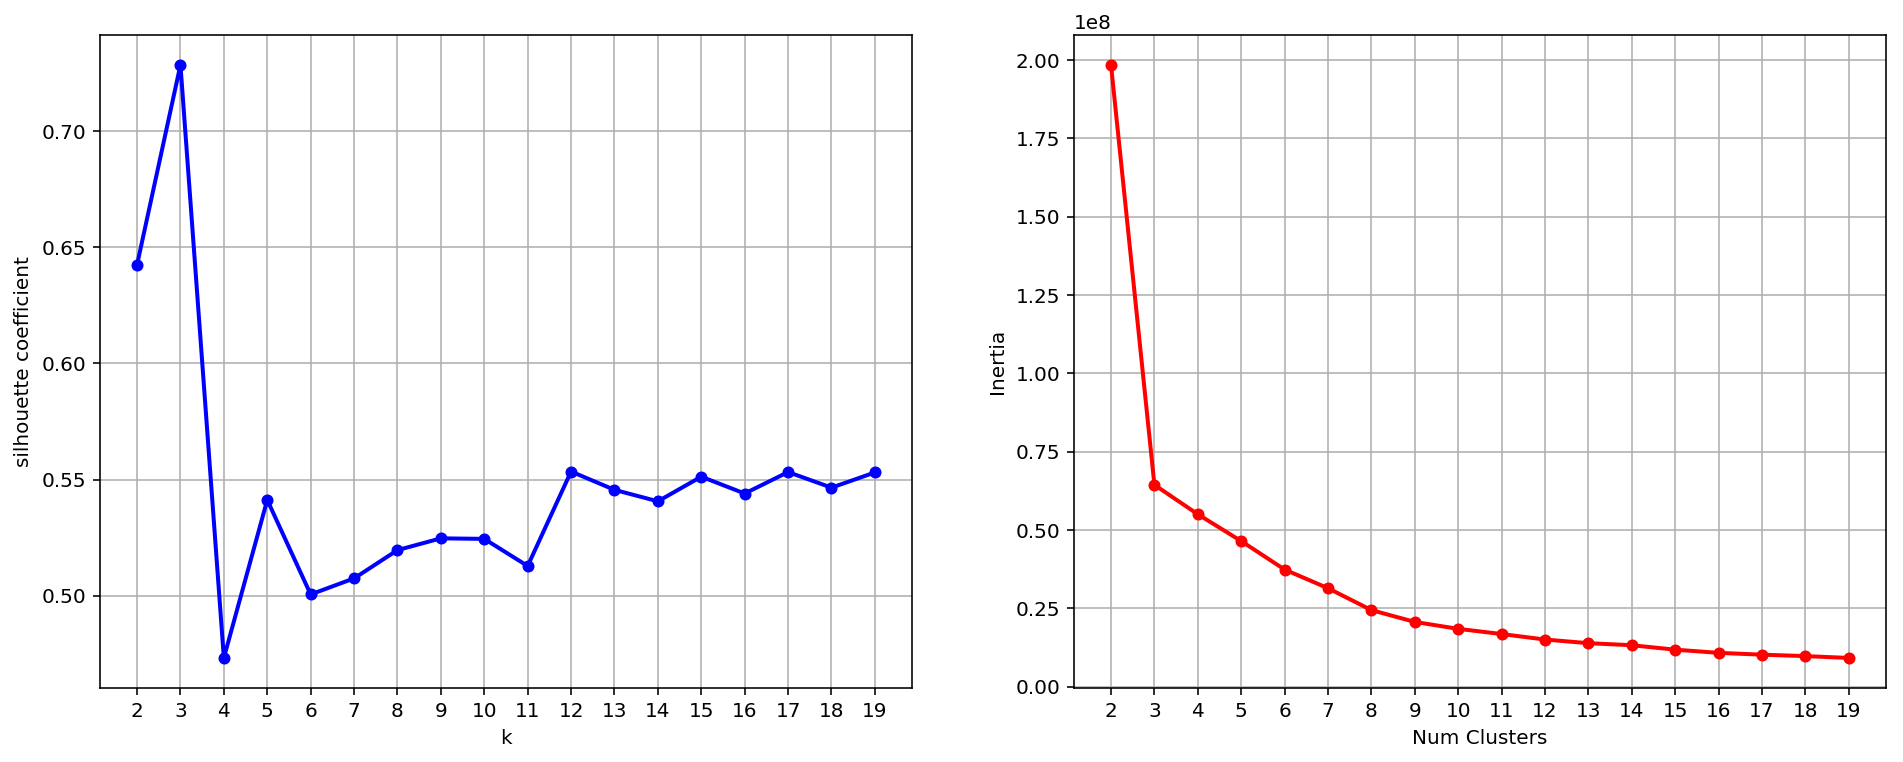

In [11]:
# Minium of clusters
MIN_K = 2
# Maximun of clusters
MAX_K  = 20
# Number of time the k-means algorithm will be run with different centroid seeds. 
N_INIT = 10


#data_clustering = dates_to_clustering(data_aggregated, list_year_month)
#data_clustering = data_aggregated[[SUBCATEGORYID_COLUMN, CASID_COLUMN]]
data_clustering = data_aggregated

plot_number_clusters(dataset = data_clustering, 
                     min_k = MIN_K,
                     max_k = MAX_K, 
                     n_init = N_INIT, 
                     title = '')

In [13]:
n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters, 
                n_init = N_INIT, 
                random_state = 1).fit(data_clustering)

clusters = kmeans.predict(data_clustering)

# Print the cluster of each chemical
for c in range(max(clusters) + 1) :
    print('Cluster', c)
    
    for casid in unique(data_clustering[CASID_COLUMN][clusters == c]) :
        print(str(casid) + " - " + unique(data[CHEMICALNAME_COLUMN][data[CASID_COLUMN] == casid])[0])
        
    print('\n')

Cluster 0
871 - Titanium dioxide
872 - Titanium dioxide
888 - Coal Tar
889 - Distillates (coal tar)
890 - Coffea arabica extract
892 - Acetic acid, retinyl ester
893 - Vitamin A palmitate
894 - Talc
895 - Coal tar extract
898 - Coal tar solution
908 - Coffee bean extract
909 - Coffee extract
911 - Extract of coffee bean
927 - Retinyl acetate
933 - Retinol palmitate
938 - Retinyl palmitate
943 - Cosmetic talc
953 - Talc
955 - Talc (powder)
957 - Vitamin A
958 - Retinol
960 - Quartz
964 - Lauramide diethanolamine
966 - Cocamide diethanolamine
967 - Cocamide diethanolamine
968 - Cocamide diethanolamine
969 - Cocamide DEA
973 - Cocamide
987 - Lauramide DEA
1001 - Mica
1002 - Musk xylene
1003 - p-Aminodiphenylamine
1004 - Sodium Bromate
1005 - Titanium dioxide
1006 - Methylene glycol
1007 - Cocamide diethanolamine (DEA)
1011 - Benzophenone
1029 - Ethanol in alcoholic beverages
1032 - Titanium dioxide (airborne, unbound particles of respirable size)
1044 - Cocamide MEA
1045 - Diethanolamine
